In [224]:
import pandas as pd
import glob
import re
from typing import List, Dict

folder_path = "Data/Measure Data/"
file_paths = [
    "2020 Star Ratings Measure Data.csv",
    "2021 Star Ratings Measure Data.csv",
    "2022 Star Ratings Measure Data.csv",
    "2023 Star Ratings Measure Data.csv",
    "2024 Star Ratings Measure Data.csv",
    "2025 Star Ratings Measure Data.csv"
]

In [225]:
dfs = []
for file_path in file_paths:
    year_match = re.search(r'(\d{4})\s+Star\s+Ratings', file_path)
    if not year_match:
        raise ValueError(f"Could not extract year from filename: {file_path}")
    year = year_match.group(1)
    print(year)
    # Read the CSV file
    df = pd.read_csv(folder_path + file_path, encoding='cp1252', skiprows=2)

    df = df.iloc[1:,:]

    # Drop columns that start with 'D'
    df = df.loc[:, ~df.columns.str.startswith('D')]

    # Add first 4 column names: CONTRACT_ID	Organization Type	Contract Name	Organization Marketing Name	Parent Organization
    df.columns = ["CONTRACT_ID", "Organization Type", "Contract Name", "Organization Marketing Name", "Parent Organization"] + list(df.columns[5:])

    # Remove the 'C\d{2}: ' prefix from the column names
    df.columns = [re.sub(r'^C\d{2}: ', 'C: ', col) for col in df.columns]

    # Remove the % sign from all columns
    df = df.replace('\%', '', regex=True)

    # For columns starting with 'C:', convert all non-numberic values to NaN
    df.loc[:, df.columns.str.startswith('C:')] = df.loc[:, df.columns.str.startswith('C:')].apply(pd.to_numeric, errors='coerce')

    # Add a column for the year
    df['Year'] = year

    dfs.append(df)

df = pd.concat(dfs, ignore_index=True, axis=0)



2020
2021
2022
2023
2024
2025


In [68]:
# df

In [213]:
df = df.loc[lambda x: x.CONTRACT_ID.isin(df.groupby('CONTRACT_ID').size().loc[lambda x: x > 1].index)]

In [226]:
# sort by plan then year
df = df.sort_values(['CONTRACT_ID', 'Year'])


In [227]:
# Get the average change in each measure for each plan YoY (drop NAs)

# get columns that start with C:
cols = df.columns[df.columns.str.startswith('C:')]
# get the change in each measure for each plan YoY
df.groupby('CONTRACT_ID')[cols].diff().mean()
df.groupby('CONTRACT_ID')[cols].diff().std()

C: Breast Cancer Screening                                                                              3.764084
C: Colorectal Cancer Screening                                                                          5.646706
C: Annual Flu Vaccine                                                                                   3.979375
C: Improving or Maintaining Physical Health                                                                  NaN
C: Improving or Maintaining Mental Health                                                                    NaN
C: Monitoring Physical Activity                                                                          3.57225
C: Adult BMI Assessment                                                                                      NaN
C: Special Needs Plan (SNP) Care Management                                                             8.005322
C: Care for Older Adults – Medication Review                                                    

In [97]:
pd.concat([df.dropna(subset=['C: Annual Flu Vaccine'], axis=0).groupby('CONTRACT_ID')[['C: Annual Flu Vaccine']].diff(),df.dropna(subset=['C: Annual Flu Vaccine'], axis=0)['CONTRACT_ID']], axis=1).dropna().groupby('CONTRACT_ID').diff().mean()

C: Annual Flu Vaccine   -1.619433
dtype: object

#### Plan

Have a predictive model for each measure.

Simple. Following metrics:

    - Last year's metric for each measure
    - 2 year trend, if available
    - 3 year trend, if available 
    - something to shape curve around threshold - beta regression

Next gen analysis, include overall insurer statistics across plans

In [228]:
c_measure_cols = df.columns[df.columns.str.startswith('C:')]

In [115]:
['CONTRACT_ID'] + list(c_measure_cols)

['CONTRACT_ID',
 'C: Breast Cancer Screening',
 'C: Colorectal Cancer Screening',
 'C: Annual Flu Vaccine',
 'C: Improving or Maintaining Physical Health',
 'C: Improving or Maintaining Mental Health',
 'C: Monitoring Physical Activity',
 'C: Adult BMI Assessment',
 'C: Special Needs Plan (SNP) Care Management',
 'C: Care for Older Adults – Medication Review',
 'C: Care for Older Adults – Functional Status Assessment',
 'C: Care for Older Adults – Pain Assessment',
 'C: Osteoporosis Management in Women who had a Fracture',
 'C: Diabetes Care – Eye Exam',
 'C: Diabetes Care – Kidney Disease Monitoring',
 'C: Diabetes Care – Blood Sugar Controlled',
 'C: Rheumatoid Arthritis Management',
 'C: Reducing the Risk of Falling',
 'C: Improving Bladder Control',
 'C: Medication Reconciliation Post-Discharge',
 'C: Plan All-Cause Readmissions',
 'C: Statin Therapy for Patients with Cardiovascular Disease',
 'C: Getting Needed Care',
 'C: Getting Appointments and Care Quickly',
 'C: Customer Serv

In [229]:
measures_2025 = {'C: Breast Cancer Screening': 1,
 'C: Colorectal Cancer Screening': 1,
 'C: Annual Flu Vaccine': 1,
 'C: Monitoring Physical Activity': 1,
 'C: Special Needs Plan (SNP) Care Management': 1,
 'C: Care for Older Adults – Medication Review': 1,
 'C: Care for Older Adults – Pain Assessment': 1,
 'C: Osteoporosis Management in Women who had a Fracture': 1,
 'C: Diabetes Care – Eye Exam': 1,
 'C: Diabetes Care – Blood Sugar Controlled':3,
 'C: Controlling Blood Pressure': 3,
 'C: Reducing the Risk of Falling': 1,
 'C: Improving Bladder Control': 1,
 'C: Medication Reconciliation Post-Discharge': 1,
 'C: Plan All-Cause Readmissions': 3,
 'C: Statin Therapy for Patients with Cardiovascular Disease': 1,
 'C: Transitions of Care': 1,
 'C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions': 1,
 'C: Getting Needed Care': 4,
 'C: Getting Appointments and Care Quickly': 4,
    'C: Customer Service': 4,
 'C: Rating of Health Care Quality': 4,
 'C: Rating of Health Plan': 4,
 'C: Care Coordination': 4,
 'C: Complaints about the Health Plan': 4,
 'C: Members Choosing to Leave the Plan': 4,
 'C: Health Plan Quality Improvement': 5,
 'C: Plan Makes Timely Decisions about Appeals': 4,
 'C: Reviewing Appeals Decisions': 4,
 'C: Call Center – Foreign Language Interpreter and TTY Availability': 4,
}

In [230]:
df.loc[df[ 'C: Controlling Blood Pressure'].isna(), 'C: Controlling Blood Pressure'] = df['C: Controlling High Blood Pressure']

In [231]:

lag_1 = df[['CONTRACT_ID'] + list(measures_2025.keys())].groupby('CONTRACT_ID').shift(1).rename(columns={col: col + '_lag1' for col in measures_2025.keys()})
diff_1 = df[['CONTRACT_ID'] + list(measures_2025.keys())].groupby('CONTRACT_ID').diff(1).rename(columns={col: col + '_diff1' for col in measures_2025.keys()})
diff_2 = df[['CONTRACT_ID'] + list(measures_2025.keys())].groupby('CONTRACT_ID').diff(2).rename(columns={col: col + '_diff2' for col in measures_2025.keys()})

In [232]:
# join on index
df = pd.concat([df, lag_1, diff_1, diff_2], axis=1)

In [134]:
# For columns with diff1, diff2, or _lag1, create a new column that is an indicator for whether that value is missing
diff_1_cols = [col for col in df.columns if '_diff1' in col]
diff_2_cols = [col for col in df.columns if '_diff2' in col]
lag_1_cols = [col for col in df.columns if '_lag1' in col]

for col in diff_1_cols + diff_2_cols + lag_1_cols:
    df[col + '_missing'] = df[col].isna().astype(int)
df

/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/627473738.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_missing'] = df[col].isna().astype(int)
/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/627473738.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_missing'] = df[col].isna().astype(int)
/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/627473738.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Improving or Maintaining Physical Health,C: Improving or Maintaining Mental Health,...,C: Customer Service_lag1_missing_missing,C: Rating of Health Care Quality_lag1_missing_missing,C: Rating of Health Plan_lag1_missing_missing,C: Care Coordination_lag1_missing_missing,C: Complaints about the Health Plan_lag1_missing_missing,C: Members Choosing to Leave the Plan_lag1_missing_missing,C: Health Plan Quality Improvement_lag1_missing_missing,C: Plan Makes Timely Decisions about Appeals_lag1_missing_missing,C: Reviewing Appeals Decisions_lag1_missing_missing,C: Call Center – Foreign Language Interpreter and TTY Availability_lag1_missing_missing
743,E0654,Employer/Union Only Direct Contract PDP,IBT VOLUNTARY EMPLOYEE BENEFITS TRUST,TEAMStar Medicare Part D Prescription Drug Pro...,IBT Voluntary Employee Benefits Trust,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1559,E0654,Employer/Union Only Direct Contract PDP,IBT VOLUNTARY EMPLOYEE BENEFITS TRUST,TEAMStar Medicare Part D Prescription Drug Pro...,IBT Voluntary Employee Benefits Trust,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
744,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1560,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2409,E3014,Employer/Union Only Direct Contract PDP,PSERS HOP PROGRAM,Pennsylvania Public School Employees Retiremen...,Commonwealth of PA Pub Schools Retirement System,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,S9701,PDP,"DEAN HEALTH INSURANCE, INC.",Navitus MedicareRx,Medica Holding Company,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4139,S9701,PDP,"DEAN HEALTH INSURANCE, INC.",Navitus MedicareRx,Medica Holding Company,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4929,S9701,PDP,"DEAN HEALTH INSURANCE, INC.",Navitus MedicareRx,Medica Holding Company,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3283,S9854,PDP,"WELLMARK ADVANTAGE HEALTH PLAN, INC.",Wellmark Advantage Health Plan,Blue Cross Blue Shield of Michigan Mutual Ins....,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [137]:
# Replace NaNs with 0 for lag1, diff1, and diff2 columns
df[diff_1.columns] = df[diff_1.columns].fillna(0)
df[diff_2.columns] = df[diff_2.columns].fillna(0)
df[lag_1.columns] = df[lag_1.columns].fillna(0)

/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/1845647148.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[diff_1.columns] = df[diff_1.columns].fillna(0)
/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/1845647148.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[diff_2.columns] = df[diff_2.columns].fillna(0)
/var/folders/l6/mn9wb7916vs71g68b6d_y95r0000gp/T/ipykernel_5330/1845647148.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. 

In [191]:
# For each measure, take only observations where the measure is not missing and run beta regression
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.othermod.betareg import BetaModel

regDf = df.dropna(subset=['C: Controlling Blood Pressure'], axis=0)[
    ['C: Controlling Blood Pressure'] + list(diff_1.columns) +
      list(diff_2.columns) + list(lag_1.columns) + [col for col in df.columns if '_missing' in col]
      ]

betaResult = BetaModel(regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001),
                        regDf.drop(columns=['C: Controlling Blood Pressure']),
                        exog_precision=regDf[['C: Controlling Blood Pressure_lag1', 'C: Controlling Blood Pressure_diff1', 'C: Controlling Blood Pressure_diff2',
                                               'C: Controlling Blood Pressure_lag1_missing', 'C: Controlling Blood Pressure_diff1_missing', 'C: Controlling Blood Pressure_diff2_missing']]
                      ).fit()

/Users/rteresi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [192]:
betaResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    BetaModel Results                                    
=========================================================================================
Dep. Variable:     C: Controlling Blood Pressure   Log-Likelihood:                 3271.6
Model:                                 BetaModel   AIC:                            -6171.
Method:                       Maximum Likelihood   BIC:                            -5167.
Date:                           Thu, 16 Jan 2025                                         
Time:                                   16:22:59                                         
No. Observations:                           1638                                         
Df Residuals:                               1452                                         
Df Model:                                    185                                         
=====================================================================================================================================================================================
                                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
C: Breast Cancer Screening_diff1                                                                                     -0.0034        nan        nan        nan         nan         nan
C: Colorectal Cancer Screening_diff1                                                                                  0.0010        nan        nan        nan         nan         nan
C: Annual Flu Vaccine_diff1                                                                                           0.0004        nan        nan        nan         nan         nan
C: Monitoring Physical Activity_diff1                                                                                 0.0011        nan        nan        nan         nan         nan
C: Special Needs Plan (SNP) Care Management_diff1                                                                     0.0014        nan        nan        nan         nan         nan
C: Care for Older Adults – Medication Review_diff1                                                                   -0.0096        nan        nan        nan         nan         nan
C: Care for Older Adults – Pain Assessment_diff1                                                                      0.0065        nan        nan        nan         nan         nan
C: Osteoporosis Management in Women who had a Fracture_diff1                                                          0.0001        nan        nan        nan         nan         nan
C: Diabetes Care – Eye Exam_diff1                                                                                     0.0007        nan        nan        nan         nan         nan
C: Diabetes Care – Blood Sugar Controlled_diff1                                                                      -0.0079        nan        nan        nan         nan         nan
C: Controlling Blood Pressure_diff1                                                                                   0.0635        nan        nan        nan         nan         nan
C: Reducing the Risk of Falling_diff1                                                                                -0.0024        nan        nan        nan         nan         nan
C: Improving Bladder Control_diff1                                                                                   -0.0011        nan        nan        nan         nan         nan
C: Medication Reconciliation Post-Discharge_diff1                                                                     0.0008        nan     

(array([  1.,   0.,   1.,   0.,   0.,   2.,   2.,   0.,   1.,   1.,   6.,
          4.,   4.,  11.,   9.,  18.,  18.,  19.,  27.,  39.,  28.,  44.,
         43.,  40.,  49.,  41.,  51.,  80.,  74.,  60.,  70.,  84.,  79.,
         73., 101.,  90.,  76.,  72.,  55.,  47.,  50.,  40.,  41.,  28.,
         17.,  14.,   9.,  10.,   3.,   6.]),
 array([0.2935352 , 0.30598165, 0.31842809, 0.33087453, 0.34332097,
        0.35576741, 0.36821386, 0.3806603 , 0.39310674, 0.40555318,
        0.41799962, 0.43044607, 0.44289251, 0.45533895, 0.46778539,
        0.48023183, 0.49267828, 0.50512472, 0.51757116, 0.5300176 ,
        0.54246404, 0.55491049, 0.56735693, 0.57980337, 0.59224981,
        0.60469625, 0.6171427 , 0.62958914, 0.64203558, 0.65448202,
        0.66692846, 0.67937491, 0.69182135, 0.70426779, 0.71671423,
        0.72916067, 0.74160711, 0.75405356, 0.7665    , 0.77894644,
        0.79139288, 0.80383932, 0.81628577, 0.82873221, 0.84117865,
        0.85362509, 0.86607153, 0.87851798, 0.

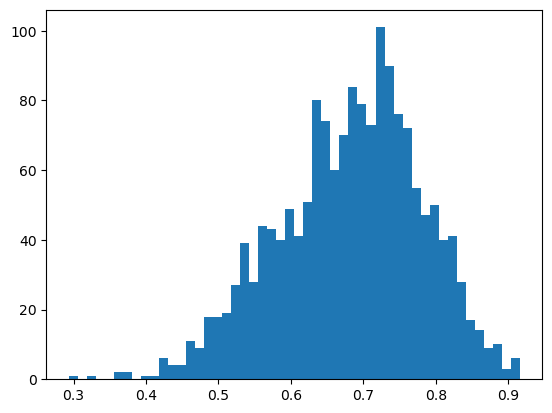

In [198]:
distribution = betaResult.get_distribution(
                            exog=regDf.drop(columns=['C: Controlling Blood Pressure']).iloc[7], 
                           exog_precision=regDf[['C: Controlling Blood Pressure_lag1', 'C: Controlling Blood Pressure_diff1', 'C: Controlling Blood Pressure_diff2',
                                               'C: Controlling Blood Pressure_lag1_missing', 'C: Controlling Blood Pressure_diff1_missing', 'C: Controlling Blood Pressure_diff2_missing']].iloc[7])
plt.hist(distribution.rvs(1638), bins=50)

In [307]:
thresholds['C11: Controlling High Blood Pressure']

[(-inf, 69.0, 1),
 (69.0, 74.0, 2),
 (74.0, 80.0, 3),
 (80.0, 85.0, 4),
 (85.0, inf, 5)]

In [305]:
sorted(distribution.rvs(1638))

[0.3267281925042219,
 0.3982400651238314,
 0.40324645358055694,
 0.40725083631403236,
 0.4132288324109065,
 0.4194757066779445,
 0.4220483958516512,
 0.423015283100983,
 0.4252498141955085,
 0.426854222182719,
 0.4281727622995315,
 0.43029790387042127,
 0.4306946479660365,
 0.4311338416822187,
 0.4312633770583721,
 0.4353768212351592,
 0.43591418466095505,
 0.4382200144712076,
 0.44101852578963907,
 0.4434594051858611,
 0.44538768551675606,
 0.447885543910718,
 0.4510054064213151,
 0.4515788792994928,
 0.45205664330008555,
 0.4537926507428206,
 0.45459922890915255,
 0.4569449410871518,
 0.4569960630259893,
 0.45803451674842366,
 0.46020027996078694,
 0.461103772174616,
 0.46370406292512284,
 0.4641045287248676,
 0.46515913576128926,
 0.46598787824842003,
 0.4660110478286339,
 0.4670649773729932,
 0.46912493931241017,
 0.4715844255896112,
 0.47158760152973617,
 0.47162944707941895,
 0.4719446877019984,
 0.47473454389103137,
 0.477985192998192,
 0.4785982260132704,
 0.4789044367513798,
 

In [ ]:
df.loc[lambda x: x.CONTRACT_ID.str.startswith('H2226') & x.Year.eq('2025') , [col for col in df.columns if 'C:' in col and not  any([col.endswith(suffix) for suffix in ['_lag1', '_diff1', '_diff2', '_missing']])]]

,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Improving or Maintaining Physical Health,C: Improving or Maintaining Mental Health,C: Monitoring Physical Activity,C: Adult BMI Assessment,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Care for Older Adults – Functional Status Assessment,...,C: Care for Older Adults - Medication Review,C: Care for Older Adults - Pain Assessment,C: Diabetes Care - Eye Exam,C: Diabetes Care - Kidney Disease Monitoring,C: Diabetes Care - Blood Sugar Controlled,C: Call Center - Foreign Language Interpreter and TTY Availability,C: Controlling Blood Pressure,C: Controlling High Blood Pressure,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,81.0,87.0,76.0,NaN,NaN,60.0,NaN,82.0,95.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.0,81.0,57.0,61.0


In [ ]:
# Define a function for getting

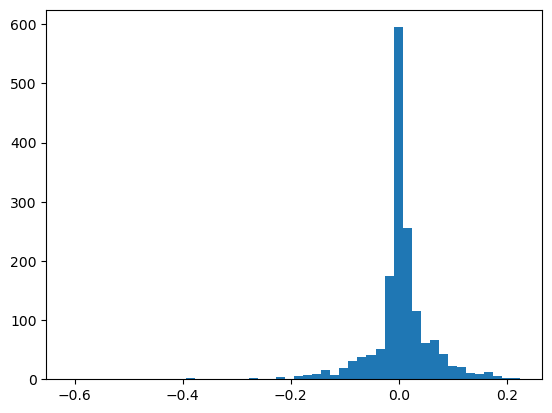

In [194]:
# plot the errors for the result in a histogram
import matplotlib.pyplot as plt
plt.hist(betaResult.resid, bins=50)
plt.show()

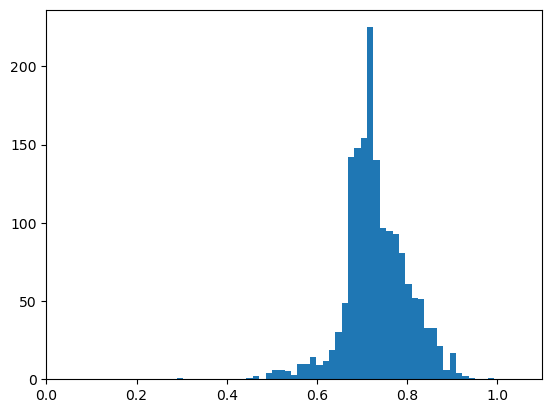

In [195]:
# plot the errors for the result in a histogram
import matplotlib.pyplot as plt
plt.hist(betaResult.predict(), bins=50)
# set limits from 0 to 1.1
plt.xlim(0,1.1)
plt.show()

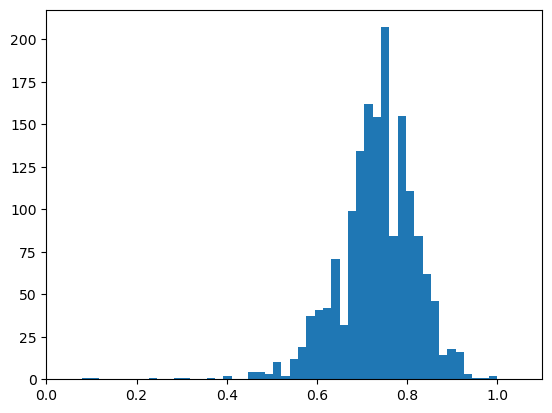

In [196]:
plt.hist(regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001),
            bins=50)
# set limits from 0 to 1.1
plt.xlim(0,1.1)
plt.show()

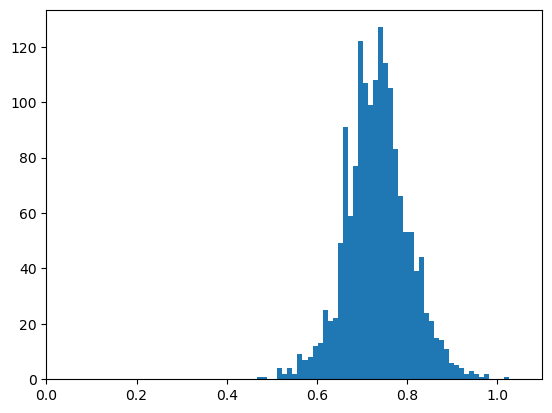

In [169]:
plt.hist(linResult.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])), bins=50)
# set limits from 0 to 1.1
plt.xlim(0,1.1)
plt.show()

In [160]:
# print percentiles of the residuals
np.percentile(np.abs(betaResult.resid), [0, 25, 50, 75, 100])


array([2.58418797e-05, 8.95846296e-03, 2.08313985e-02, 4.28690337e-02,
       5.80725219e-01])

In [ ]:
# plot RMSE

In [151]:
betaResult.summary()

# Get RMSE
np.sqrt(np.mean((betaResult.predict() - regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))**2))


0.05367455436874609

In [157]:
# R squared value
1 - np.sum((betaResult.resid)**2) / np.sum((regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001) - np.mean(regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001)))**2)

0.6228538056324352

0.053024082597798415
0.6319395426113146


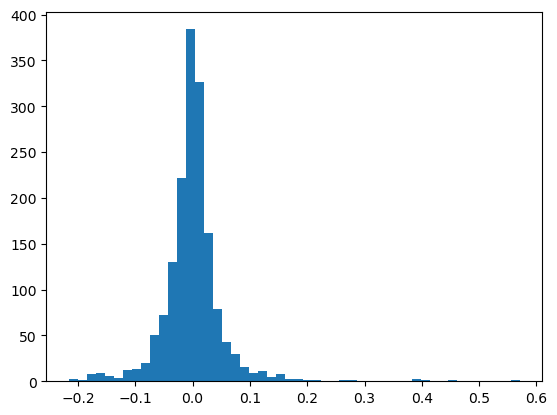

In [164]:
# linear regression with only lag1
regDf = df.dropna(subset=['C: Controlling Blood Pressure'], axis=0)[
    ['C: Controlling Blood Pressure'] + list(diff_1.columns) +
      list(diff_2.columns) + list(lag_1.columns) + [col for col in df.columns if '_missing' in col]
      ]

linResult = LinearRegression().fit(regDf.drop(columns=['C: Controlling Blood Pressure']), regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))

# plot the errors for the result in a histogram
plt.hist(linResult.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])) - regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001), bins=50)

# print RMSE
print(np.sqrt(np.mean((linResult.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])) - regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))**2))
)
# R squared value
print(linResult.score(regDf.drop(columns=['C: Controlling Blood Pressure']), regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001)))


(array([  1.,   1.,   0.,   0.,   4.,   2.,   4.,   2.,   9.,   7.,   8.,
         12.,  13.,  25.,  21.,  22.,  49.,  91.,  59.,  77., 122., 107.,
         99., 108., 127., 114., 105.,  83.,  66.,  53.,  53.,  39.,  44.,
         24.,  21.,  15.,  14.,  11.,   6.,   5.,   4.,   2.,   3.,   2.,
          1.,   2.,   0.,   0.,   0.,   1.]),
 array([0.467249  , 0.47844692, 0.48964484, 0.50084276, 0.51204068,
        0.5232386 , 0.53443652, 0.54563444, 0.55683236, 0.56803028,
        0.5792282 , 0.59042612, 0.60162404, 0.61282196, 0.62401988,
        0.63521781, 0.64641573, 0.65761365, 0.66881157, 0.68000949,
        0.69120741, 0.70240533, 0.71360325, 0.72480117, 0.73599909,
        0.74719701, 0.75839493, 0.76959285, 0.78079077, 0.79198869,
        0.80318661, 0.81438453, 0.82558245, 0.83678037, 0.8479783 ,
        0.85917622, 0.87037414, 0.88157206, 0.89276998, 0.9039679 ,
        0.91516582, 0.92636374, 0.93756166, 0.94875958, 0.9599575 ,
        0.97115542, 0.98235334, 0.99355126, 1.

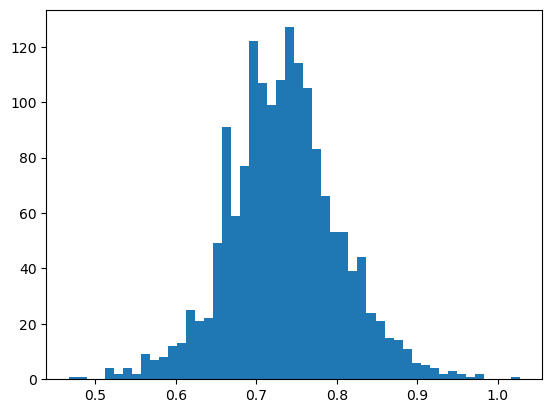

In [165]:
plt.hist(linResult.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])), bins=50)

In [153]:
# Get RMSE using linear regression
regDf = df.dropna(subset=['C: Controlling Blood Pressure'], axis=0)[
    ['C: Controlling Blood Pressure'] + list(diff_1.columns) +
      list(diff_2.columns) + list(lag_1.columns) + [col for col in df.columns if '_missing' in col]
      ]

lm = LinearRegression().fit(regDf.drop(columns=['C: Controlling Blood Pressure']), regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))

np.sqrt(np.mean((lm.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])) - regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))**2))

# Get RMSE using logistic regression
from sklearn.linear_model import LogisticRegression

regDf = df.dropna(subset=['C: Controlling Blood Pressure'], axis=0)[
    ['C: Controlling Blood Pressure'] + list(diff_1.columns) +
      list(diff_2.columns) + list(lag_1.columns) + [col for col in df.columns if '_missing' in col]
      ]

lm = LogisticRegression().fit(regDf.drop(columns=['C: Controlling Blood Pressure']), regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))

np.sqrt(np.mean((lm.predict(regDf.drop(columns=['C: Controlling Blood Pressure'])) - regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100)-.0001))**2))

ValueError: Unknown label type: 'continuous'

In [146]:
regDf['C: Controlling Blood Pressure'].apply(lambda x: (x / 100).describe()

count    1638.000000
mean        0.734096
std         0.087427
min         0.080000
25%         0.690000
50%         0.740000
75%         0.790000
max         1.000000
Name: C: Controlling Blood Pressure, dtype: float64

In [206]:
import pandas as pd
import re

def parse_threshold(threshold_str: str) -> tuple:
    """
    Parse threshold strings like '>= 53 % to < 67 %' or '< 53 %' into numeric bounds
    Also handles negative numbers and relative change metrics
    Returns tuple of (lower_bound, upper_bound)
    """
    if pd.isna(threshold_str):
        return None
        
    # Clean the string by removing '%' and extra spaces
    threshold_str = threshold_str.replace('%', '').strip()
    
    try:
        if 'to' in threshold_str:
            # Handle range case: '>= -0.179809 to < 0'
            lower_str, upper_str = threshold_str.split('to')
            # Updated regex to handle negative numbers
            lower_bound = float(re.findall(r'>=?\s*([-]?\d+\.?\d*)', lower_str)[0])
            upper_bound = float(re.findall(r'<=?\s*([-]?\d+\.?\d*)', upper_str)[0])
            return (lower_bound, upper_bound)
        elif threshold_str.startswith('<'):
            # Handle less than case: '< -0.179809'
            upper_bound = float(re.findall(r'<=?\s*([-]?\d+\.?\d*)', threshold_str)[0])
            return (-float('inf'), upper_bound)
        elif threshold_str.startswith('>='):
            # Handle greater than or equal case: '>= 0.421057'
            lower_bound = float(re.findall(r'>=\s*([-]?\d+\.?\d*)', threshold_str)[0])
            return (lower_bound, float('inf'))
        elif threshold_str.startswith('>'):
            # Handle greater than case: '> -0.5'
            lower_bound = float(re.findall(r'>\s*([-]?\d+\.?\d*)', threshold_str)[0])
            return (lower_bound, float('inf'))
        elif threshold_str.startswith('100'):
            return (100, 100)
        else:
            raise ValueError(f"Unexpected threshold format: {threshold_str}")
    except IndexError as e:
        raise ValueError(f"Could not parse threshold: {threshold_str}") from e


def create_measure_thresholds(df: pd.DataFrame) -> dict:
    """
    Transform the threshold dataframe into a dictionary of measure thresholds
    Returns dict with measure IDs as keys and lists of (lower_bound, upper_bound, star_rating) as values
    """
    measure_thresholds = {}
    
    # Get the actual star rating rows (skip header row)
    star_rows = df[df.iloc[:, 0].str.contains('star', na=False, case=False)]
    
    # Iterate through each measure (column)
    for measure in df.columns[1:]:  # Skip the star rating column
        thresholds = []
        # Iterate through each star rating level
        for idx, row in star_rows.iterrows():
            star_str = row.iloc[0]
            try:
                star_rating = int(star_str.lower().replace('star', '').strip())
            except (ValueError, AttributeError):
                continue
                
            threshold_str = row[measure]
            
            if pd.notna(threshold_str):
                try:
                    parsed = parse_threshold(threshold_str)
                    if parsed:
                        lower_bound, upper_bound = parsed
                        thresholds.append((lower_bound, upper_bound, star_rating))
                except ValueError as e:
                    print(f"Warning: Could not parse threshold '{threshold_str}' for {measure}: {e}")
                    continue
        
        if thresholds:  # Only add measures that have valid thresholds
            measure_thresholds[measure] = sorted(thresholds, key=lambda x: x[2])  # Sort by star rating
    
    return measure_thresholds

def get_star_rating(measure_id: str, score: float, thresholds: dict) -> int:
    """
    Get the star rating for a specific measure and score
    
    Args:
        measure_id: The measure identifier (e.g., 'C01: Breast Cancer Screening')
        score: The numeric score (e.g., 74)
        thresholds: Dictionary of measure thresholds
    
    Returns:
        int: Star rating (1-5)
        
    Raises:
        KeyError: If measure_id is not found in thresholds
        ValueError: If score doesn't fall into any threshold range
    """
    if measure_id not in thresholds:
        raise KeyError(f"Unknown measure ID: {measure_id}")
    
    measure_ranges = thresholds[measure_id]
    
    for lower_bound, upper_bound, star_rating in measure_ranges:
        if lower_bound <= score < upper_bound:
            return star_rating
            
    # Special case: check if score equals the highest threshold
    highest_range = max(measure_ranges, key=lambda x: x[2])
    if score >= highest_range[0]:
        return highest_range[2]
            
    raise ValueError(f"Score {score} does not fall into any defined range for measure {measure_id}")

def main():
    # Read the thresholds CSV
    df = pd.read_csv('Data/Cutpoints/2025 Star Ratings Part C Cut Points.csv', encoding='cp1252', skiprows=2)
    
    # Create the thresholds dictionary
    thresholds = create_measure_thresholds(df)
    
    print(thresholds)
    # Example usage
    test_cases = [
        ('C01: Breast Cancer Screening', 74),
        ('C02: Colorectal Cancer Screening', 85),
        ('C03: Annual Flu Vaccine', 63)
    ]
    
    for measure_id, score in test_cases:
        try:
            stars = get_star_rating(measure_id, score, thresholds)
            print(f"{measure_id} score {score} = {stars} stars")
        except (KeyError, ValueError) as e:
            print(f"Error: {e}")

if __name__ == '__main__':
    main()

{'C01: Breast Cancer Screening': [(-inf, 53.0, 1), (53.0, 67.0, 2), (67.0, 75.0, 3), (75.0, 82.0, 4), (82.0, inf, 5)], 'C02: Colorectal Cancer Screening': [(-inf, 53.0, 1), (53.0, 65.0, 2), (65.0, 75.0, 3), (75.0, 83.0, 4), (83.0, inf, 5)], 'C03: Annual Flu Vaccine': [(-inf, 61.0, 1), (61.0, 65.0, 2), (65.0, 71.0, 3), (71.0, 76.0, 4), (76.0, inf, 5)], 'C04: Monitoring Physical Activity': [(-inf, 41.0, 1), (41.0, 47.0, 2), (47.0, 52.0, 3), (52.0, 60.0, 4), (60.0, inf, 5)], 'C05: Special Needs Plan (SNP) Care Management': [(-inf, 46.0, 1), (46.0, 62.0, 2), (62.0, 76.0, 3), (76.0, 89.0, 4), (89.0, inf, 5)], 'C06: Care for Older Adults – Medication Review': [(-inf, 53.0, 1), (53.0, 80.0, 2), (80.0, 92.0, 3), (92.0, 98.0, 4), (98.0, inf, 5)], 'C07: Care for Older Adults – Pain Assessment': [(-inf, 60.0, 1), (60.0, 81.0, 2), (81.0, 92.0, 3), (92.0, 96.0, 4), (96.0, inf, 5)], 'C08: Osteoporosis Management in Women who had a Fracture': [(-inf, 27.0, 1), (27.0, 39.0, 2), (39.0, 52.0, 3), (52.0,

In [303]:
thresholds

{'C01: Breast Cancer Screening': [(-inf, 53.0, 1),
  (53.0, 67.0, 2),
  (67.0, 75.0, 3),
  (75.0, 82.0, 4),
  (82.0, inf, 5)],
 'C02: Colorectal Cancer Screening': [(-inf, 53.0, 1),
  (53.0, 65.0, 2),
  (65.0, 75.0, 3),
  (75.0, 83.0, 4),
  (83.0, inf, 5)],
 'C03: Annual Flu Vaccine': [(-inf, 61.0, 1),
  (61.0, 65.0, 2),
  (65.0, 71.0, 3),
  (71.0, 76.0, 4),
  (76.0, inf, 5)],
 'C04: Monitoring Physical Activity': [(-inf, 41.0, 1),
  (41.0, 47.0, 2),
  (47.0, 52.0, 3),
  (52.0, 60.0, 4),
  (60.0, inf, 5)],
 'C05: Special Needs Plan (SNP) Care Management': [(-inf, 46.0, 1),
  (46.0, 62.0, 2),
  (62.0, 76.0, 3),
  (76.0, 89.0, 4),
  (89.0, inf, 5)],
 'C06: Care for Older Adults – Medication Review': [(-inf, 53.0, 1),
  (53.0, 80.0, 2),
  (80.0, 92.0, 3),
  (92.0, 98.0, 4),
  (98.0, inf, 5)],
 'C07: Care for Older Adults – Pain Assessment': [(-inf, 60.0, 1),
  (60.0, 81.0, 2),
  (81.0, 92.0, 3),
  (92.0, 96.0, 4),
  (96.0, inf, 5)],
 'C08: Osteoporosis Management in Women who had a Fractu

In [205]:
pd.read_csv('Data/Cutpoints/2025 Star Ratings Part C Cut Points.csv', encoding='cp1252')

,2025 Part C Performance Metrics Threshold for Star Assignments,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Number of Stars Displayed on the Plan Finder Tool,"HD1: Staying Healthy: Screenings, Tests and Va...",NaN,NaN,NaN,HD2: Managing Chronic (Long Term) Conditions,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,C01: Breast Cancer Screening,C02: Colorectal Cancer Screening,C03: Annual Flu Vaccine,C04: Monitoring Physical Activity,C05: Special Needs Plan (SNP) Care Management,C06: Care for Older Adults – Medication Review,C07: Care for Older Adults – Pain Assessment,C08: Osteoporosis Management in Women who had ...,C09: Diabetes Care – Eye Exam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,03/2024 – 06/2024,07/17/2023 – 11/01/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1star,< 53 %,< 53 %,< 61,< 41 %,< 46 %,< 53 %,< 60 %,< 27 %,< 57 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2star,>= 53 % to < 67 %,>= 53 % to < 65 %,>= 61 to < 65,>= 41 % to < 47 %,>= 46 % to < 62 %,>= 53 % to < 80 %,>= 60 % to < 81 %,>= 27 % to < 39 %,>= 57 % to < 70 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3star,>= 67 % to < 75 %,>= 65 % to < 75 %,>= 65 to < 71,>= 47 % to < 52 %,>= 62 % to < 76 %,>= 80 % to < 92 %,>= 81 % to < 92 %,>= 39 % to < 52 %,>= 70 % to < 77 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4star,>= 75 % to < 82 %,>= 75 % to < 83 %,>= 71 to < 76,>= 52 % to < 60 %,>= 76 % to < 89 %,>= 92 % to < 98 %,>= 92 % to < 96 %,>= 52 % to < 71 %,>= 77 % to < 83 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5star,>= 82 %,>= 83 %,>= 76,>= 60 %,>= 89 %,>= 98 %,>= 96 %,>= 71 %,>= 83 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
threshold_df = pd.read_csv('Data/Cutpoints/2025 Star Ratings Part C Cut Points.csv', encoding='cp1252', skiprows=2)

# Create the thresholds dictionary
thresholds = create_measure_thresholds(threshold_df)


In [208]:
thresholds

{'C01: Breast Cancer Screening': [(-inf, 53.0, 1),
  (53.0, 67.0, 2),
  (67.0, 75.0, 3),
  (75.0, 82.0, 4),
  (82.0, inf, 5)],
 'C02: Colorectal Cancer Screening': [(-inf, 53.0, 1),
  (53.0, 65.0, 2),
  (65.0, 75.0, 3),
  (75.0, 83.0, 4),
  (83.0, inf, 5)],
 'C03: Annual Flu Vaccine': [(-inf, 61.0, 1),
  (61.0, 65.0, 2),
  (65.0, 71.0, 3),
  (71.0, 76.0, 4),
  (76.0, inf, 5)],
 'C04: Monitoring Physical Activity': [(-inf, 41.0, 1),
  (41.0, 47.0, 2),
  (47.0, 52.0, 3),
  (52.0, 60.0, 4),
  (60.0, inf, 5)],
 'C05: Special Needs Plan (SNP) Care Management': [(-inf, 46.0, 1),
  (46.0, 62.0, 2),
  (62.0, 76.0, 3),
  (76.0, 89.0, 4),
  (89.0, inf, 5)],
 'C06: Care for Older Adults – Medication Review': [(-inf, 53.0, 1),
  (53.0, 80.0, 2),
  (80.0, 92.0, 3),
  (92.0, 98.0, 4),
  (98.0, inf, 5)],
 'C07: Care for Older Adults – Pain Assessment': [(-inf, 60.0, 1),
  (60.0, 81.0, 2),
  (81.0, 92.0, 3),
  (92.0, 96.0, 4),
  (96.0, inf, 5)],
 'C08: Osteoporosis Management in Women who had a Fractu

In [221]:
df.loc[lambda x: x.CONTRACT_ID.eq('H2226')]

,CONTRACT_ID,Organization Type,Contract Name,Organization Marketing Name,Parent Organization,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Improving or Maintaining Physical Health,C: Improving or Maintaining Mental Health,...,C: Customer Service_diff2,C: Rating of Health Care Quality_diff2,C: Rating of Health Plan_diff2,C: Care Coordination_diff2,C: Complaints about the Health Plan_diff2,C: Members Choosing to Leave the Plan_diff2,C: Health Plan Quality Improvement_diff2,C: Plan Makes Timely Decisions about Appeals_diff2,C: Reviewing Appeals Decisions_diff2,C: Call Center – Foreign Language Interpreter and TTY Availability_diff2


In [210]:
df

,Unnamed: 0,C01: Breast Cancer Screening,C02: Colorectal Cancer Screening,C03: Annual Flu Vaccine,C04: Monitoring Physical Activity,C05: Special Needs Plan (SNP) Care Management,C06: Care for Older Adults – Medication Review,C07: Care for Older Adults – Pain Assessment,C08: Osteoporosis Management in Women who had a Fracture,C09: Diabetes Care – Eye Exam,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,NaN,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,03/2024 – 06/2024,07/17/2023 – 11/01/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,01/01/2023 – 12/31/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1star,< 53 %,< 53 %,< 61,< 41 %,< 46 %,< 53 %,< 60 %,< 27 %,< 57 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2star,>= 53 % to < 67 %,>= 53 % to < 65 %,>= 61 to < 65,>= 41 % to < 47 %,>= 46 % to < 62 %,>= 53 % to < 80 %,>= 60 % to < 81 %,>= 27 % to < 39 %,>= 57 % to < 70 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3star,>= 67 % to < 75 %,>= 65 % to < 75 %,>= 65 to < 71,>= 47 % to < 52 %,>= 62 % to < 76 %,>= 80 % to < 92 %,>= 81 % to < 92 %,>= 39 % to < 52 %,>= 70 % to < 77 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4star,>= 75 % to < 82 %,>= 75 % to < 83 %,>= 71 to < 76,>= 52 % to < 60 %,>= 76 % to < 89 %,>= 92 % to < 98 %,>= 92 % to < 96 %,>= 52 % to < 71 %,>= 77 % to < 83 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5star,>= 82 %,>= 83 %,>= 76,>= 60 %,>= 89 %,>= 98 %,>= 96 %,>= 71 %,>= 83 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
df.loc[lambda x: x.CONTRACT_ID.str.startswith('H2226') & x.Year.eq('2025'), [col for col in df.columns if 'C:' in col and not  any([col.endswith(suffix) for suffix in ['_lag1', '_diff1', '_diff2', '_missing']])]]

,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Improving or Maintaining Physical Health,C: Improving or Maintaining Mental Health,C: Monitoring Physical Activity,C: Adult BMI Assessment,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Care for Older Adults – Functional Status Assessment,...,C: Care for Older Adults - Medication Review,C: Care for Older Adults - Pain Assessment,C: Diabetes Care - Eye Exam,C: Diabetes Care - Kidney Disease Monitoring,C: Diabetes Care - Blood Sugar Controlled,C: Call Center - Foreign Language Interpreter and TTY Availability,C: Controlling Blood Pressure,C: Controlling High Blood Pressure,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,81.0,87.0,76.0,NaN,NaN,60.0,NaN,82.0,95.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.0,81.0,57.0,61.0


In [269]:
import pandas as pd
import numpy as np

def calculate_star_ratings(scores_df: pd.DataFrame, 
                         thresholds: dict, 
                         measure_weights: dict) -> tuple:
    """
    Calculate star ratings and distances to next threshold for each measure
    
    Args:
        scores_df: DataFrame with measure scores
        thresholds: Dictionary of measure thresholds from create_measure_thresholds()
        measure_weights: Dictionary mapping measure names to their weights
        
    Returns:
        tuple: (star_ratings_df, distance_to_next_df, weighted_average)
    """
    # Initialize output DataFrames with same index as input
    star_ratings = pd.DataFrame(index=scores_df.index)
    distances = pd.DataFrame(index=scores_df.index)
    
    # Process each measure
    for measure in scores_df.columns:
        if measure not in measure_weights:
            continue
            
        # Get the measure's star ratings and distances
        stars = []
        next_thresholds = []
        
        for score in scores_df[measure]:
            if pd.isna(score):
                stars.append(np.nan)
                next_thresholds.append(np.nan)
                continue
                
            try:
                # Get star rating
                star = get_star_rating(measure, score, thresholds)
                stars.append(star)
                
                # Calculate distance to next threshold
                measure_ranges = thresholds[measure]
                current_range = [r for r in measure_ranges if r[2] == star][0]
                
                if star < 5:
                    next_range = [r for r in measure_ranges if r[2] == star + 1][0]
                    distance = next_range[0] - score
                else:
                    distance = 0
                    
                next_thresholds.append(distance)
                
            except (KeyError, ValueError):
                stars.append(np.nan)
                next_thresholds.append(np.nan)
        
        star_ratings[measure] = stars
        distances[measure] = next_thresholds
    
    # Calculate weighted average
    weighted_scores = []
    for idx in star_ratings.index:
        total_weight = 0
        total_score = 0
        
        for measure, weight in measure_weights.items():
            if measure in star_ratings.columns:
                star = star_ratings.loc[idx, measure]
                if not pd.isna(star):
                    total_score += star * weight
                    total_weight += weight
        
        if total_weight > 0:
            weighted_scores.append(total_score / total_weight)
        else:
            weighted_scores.append(np.nan)
    
    return star_ratings, distances, pd.Series(weighted_scores, index=scores_df.index)

def format_results(star_ratings: pd.DataFrame, 
                  distances: pd.DataFrame, 
                  weighted_avg: pd.Series,
                  measure_weights: dict) -> pd.DataFrame:
    """
    Format the results into a readable summary DataFrame
    """
    summary = pd.DataFrame()
    
    for measure in star_ratings.columns:
        if measure in measure_weights:
            summary[f"{measure} (Weight: {measure_weights[measure]})"] = star_ratings[measure].map(str) + \
                " stars (+" + distances[measure].round(3).map(str) + " to next)"
            
    summary['Weighted Average'] = weighted_avg.round(3).map(str) + " stars"
    
    return summary

# Example usage:
def main(scores_df, thresholds, measure_weights):
    # Calculate ratings and distances
    star_ratings, distances, weighted_avg = calculate_star_ratings(
        scores_df, thresholds, measure_weights
    )
    
    # Format results
    summary = format_results(star_ratings, distances, weighted_avg, measure_weights)
    
    return star_ratings, distances, weighted_avg, summary

results = main(df.loc[lambda x: x.CONTRACT_ID.str.startswith('H2226') & x.Year.eq('2025') , [col for col in df.columns if 'C:' in col and not  any([col.endswith(suffix) for suffix in ['_lag1', '_diff1', '_diff2', '_missing']])]],
     formatted_thresholds,
     measures_2025)

In [265]:
formatted_thresholds = {}

# take out C01, C02, ..., C25, etc. and just put C: measure name
for key in thresholds.keys():
    formatted_thresholds[key.split(':')[0][0] + ':' + key.split(':')[1]] = thresholds[key]

In [270]:
results[0]

,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Monitoring Physical Activity,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Care for Older Adults – Pain Assessment,C: Osteoporosis Management in Women who had a Fracture,C: Diabetes Care – Eye Exam,C: Diabetes Care – Blood Sugar Controlled,...,C: Care Coordination,C: Complaints about the Health Plan,C: Members Choosing to Leave the Plan,C: Health Plan Quality Improvement,C: Plan Makes Timely Decisions about Appeals,C: Reviewing Appeals Decisions,C: Call Center – Foreign Language Interpreter and TTY Availability,C: Controlling Blood Pressure,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,4,5,5,5,4,4,5,2,5,4,...,3,4,5,NaN,5,5,4,NaN,3,4


In [271]:
results[1]

,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Monitoring Physical Activity,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Care for Older Adults – Pain Assessment,C: Osteoporosis Management in Women who had a Fracture,C: Diabetes Care – Eye Exam,C: Diabetes Care – Blood Sugar Controlled,...,C: Care Coordination,C: Complaints about the Health Plan,C: Members Choosing to Leave the Plan,C: Health Plan Quality Improvement,C: Plan Makes Timely Decisions about Appeals,C: Reviewing Appeals Decisions,C: Call Center – Foreign Language Interpreter and TTY Availability,C: Controlling Blood Pressure,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,1.0,0,0,0,7.0,3.0,0,3.0,0,4.0,...,1.0,-inf,0,NaN,0,0,2.0,NaN,6.0,8.0


In [272]:
results[2]

4291    3.661538
dtype: float64

In [278]:
rating_cutoffs = [ 2.75, 3.25, 3.75, 4.25, 4.75]
# get the sum of weights for columns with non NA values
print(results[0].apply(lambda x: np.sum([measures_2025[col] for col in x.dropna().index]), axis=1).values)

# get next highest cutoff for results 3.66
next_highest_cutoff = min([cutoff for cutoff in rating_cutoffs if cutoff > 3.66])

# sum of weights in calculation
sum([measures_2025[col] for col in results[0].iloc[0].dropna().index])

# get the number of points needed to get to next star rating
points_needed = next_highest_cutoff * sum([measures_2025[col] for col in results[0].iloc[0].dropna().index]) - sum([measures_2025[col] for col in results[0].iloc[0].dropna().index]) * 3.66

[65]


5.849999999999994

In [286]:
import pandas as pd
import numpy as np

def calculate_improvement_path(star_ratings: pd.DataFrame, 
                            distances: pd.DataFrame,
                            measure_weights: dict,
                            current_weighted_avg: float,
                            target_rating: float) -> pd.DataFrame:
    """
    Calculate the most efficient path to reach the next star rating level
    
    Args:
        star_ratings: DataFrame with current star ratings
        distances: DataFrame with distances to next star level
        measure_weights: Dictionary of measure weights
        current_weighted_avg: Current weighted average star rating
        target_rating: Target star rating to reach
        
    Returns:
        DataFrame with ordered improvement opportunities
    """
    # Get the first row since we're analyzing one plan
    current_stars = star_ratings.iloc[0]
    current_distances = distances.iloc[0]
    
    # Calculate total weight for measures that have ratings
    total_weight = sum([measure_weights[col] for col in current_stars.dropna().index])
    
    # Create list of improvement opportunities
    opportunities = []
    
    for measure in current_stars.index:
        if measure not in measure_weights:
            continue
            
        star = current_stars[measure]
        distance = current_distances[measure]
        weight = measure_weights[measure]
        
        # Skip measures that are NA, already 5 stars, or have no distance data
        if pd.isna(star) or star == 5 or pd.isna(distance):
            continue
            
        # Calculate impact of improving this measure by one star
        rating_impact = weight / total_weight
            
        opportunities.append({
            'Measure': measure,
            'Current_Stars': star,
            'Weight': weight,
            'Distance_to_Next': distance,
            'Distance_per_Weight': abs(distance) / weight,
            'Single_Measure_Impact': rating_impact
        })
    
    # Convert to DataFrame and sort by efficiency (absolute distance per weight)
    path_df = pd.DataFrame(opportunities)
    if len(path_df) == 0:
        return pd.DataFrame()
        
    path_df = path_df.sort_values('Distance_per_Weight')
    
    # Calculate cumulative weights and rating impacts
    path_df['Cumulative_Weight'] = path_df['Weight'].cumsum()
    path_df['Cumulative_Rating_Impact'] = current_weighted_avg + path_df['Single_Measure_Impact'].cumsum()
    
    # Format the final output
    output_df = path_df[[
        'Measure', 
        'Weight', 
        'Distance_to_Next',
        'Distance_per_Weight',
        'Cumulative_Weight',
        'Cumulative_Rating_Impact'
    ]].round(3)
    
    # Add how many measures needed to reach target
    target_idx = (output_df['Cumulative_Rating_Impact'] >= target_rating).idxmax() \
        if any(output_df['Cumulative_Rating_Impact'] >= target_rating) else None
    
    if target_idx is not None:
        measures_needed = output_df.iloc[:target_idx + 1]
        print(f"\nTo reach {target_rating} stars, improve these {len(measures_needed)} measures:")
        for _, row in measures_needed.iterrows():
            print(f"- {row['Measure']}: {row['Distance_to_Next']:.3f} points needed (weight: {row['Weight']})")
    
    return output_df

def main(results, measures_2025, current_weighted_avg, target_rating):
    """
    Main function to analyze improvement path
    """
    star_ratings, distances = results[0], results[1]
    
    improvement_path = calculate_improvement_path(
        star_ratings,
        distances,
        measures_2025,
        current_weighted_avg,
        target_rating
    )
    
    return improvement_path

In [287]:
improvement_path = main(results, measures_2025, 3.66, 3.75)
print(improvement_path)


To reach 3.75 stars, improve these 12 measures:
- C: Care Coordination: 1.000 points needed (weight: 4)
- C: Rating of Health Care Quality: 1.000 points needed (weight: 4)
- C: Customer Service: 1.000 points needed (weight: 4)
- C: Getting Needed Care: 2.000 points needed (weight: 4)
- C: Call Center – Foreign Language Interpreter and TTY Availability: 2.000 points needed (weight: 4)
- C: Getting Appointments and Care Quickly: 2.000 points needed (weight: 4)
- C: Statin Therapy for Patients with Cardiovascular Disease: 1.000 points needed (weight: 1)
- C: Breast Cancer Screening: 1.000 points needed (weight: 1)
- C: Medication Reconciliation Post-Discharge: 1.000 points needed (weight: 1)
- C: Plan All-Cause Readmissions: -3.000 points needed (weight: 3)
- C: Diabetes Care – Blood Sugar Controlled: 4.000 points needed (weight: 3)
- C: Osteoporosis Management in Women who had a Fracture: 3.000 points needed (weight: 1)
                                              Measure  Weight  \
12

In [288]:
from tabulate import tabulate
import pandas as pd
import numpy as np

def generate_improvement_report(improvement_path: pd.DataFrame, 
                             current_rating: float,
                             target_rating: float,
                             points_needed: float) -> str:
    """
    Generate a formatted report of the star rating improvement path
    
    Args:
        improvement_path: DataFrame from calculate_improvement_path
        current_rating: Current star rating
        target_rating: Target star rating
        points_needed: Points needed to reach target rating
        
    Returns:
        Formatted string report
    """
    report = []
    
    # Header section
    report.append("=" * 80)
    report.append("STAR RATING IMPROVEMENT ANALYSIS")
    report.append("=" * 80)
    
    # Summary section
    report.append("\nCURRENT STATUS:")
    report.append(f"Current Rating: {current_rating:.2f} stars")
    report.append(f"Target Rating:  {target_rating:.2f} stars")
    report.append(f"Points Needed: {points_needed:.2f}")
    
    # Format the improvement path table
    table_data = improvement_path.copy()
    
    # Rename columns for clarity
    table_data.columns = [
        'Measure',
        'Weight',
        'Points to Next ★',
        'Points/Weight',
        'Cumulative Weight',
        'Projected Rating'
    ]
    
    # Add star improvement indicator
    table_data['Improvement'] = '★ → ★★'
    
    # Format numeric columns
    for col in ['Points to Next ★', 'Points/Weight', 'Projected Rating']:
        table_data[col] = table_data[col].round(3)
    
    # Create the main table
    report.append("\nIMPROVEMENT OPPORTUNITIES (Ordered by Efficiency):")
    report.append(tabulate(
        table_data, 
        headers='keys',
        tablefmt='grid',
        showindex=False
    ))
    
    # Add recommendations section
    target_idx = (improvement_path['Cumulative_Rating_Impact'] >= target_rating).idxmax() \
        if any(improvement_path['Cumulative_Rating_Impact'] >= target_rating) else None
    
    if target_idx is not None:
        measures_needed = improvement_path.iloc[:target_idx + 1]
        report.append("\nRECOMMENDED IMPROVEMENT PATH:")
        report.append(f"To reach {target_rating} stars, focus on these {len(measures_needed)} measures:")
        
        for idx, row in measures_needed.iterrows():
            impact = row['Cumulative_Rating_Impact'] - \
                    (measures_needed.iloc[idx-1]['Cumulative_Rating_Impact'] if idx > 0 else current_rating)
            report.append(
                f"\n{idx + 1}. {row['Measure']}"
                f"\n   → Improvement needed: {abs(row['Distance_to_Next']):.3f} points"
                f"\n   → Weight: {row['Weight']}"
                f"\n   → Rating impact: +{impact:.3f} stars"
                f"\n   → Projected rating after improvement: {row['Cumulative_Rating_Impact']:.3f} stars"
            )
    else:
        report.append("\nNOTE: Target rating cannot be reached by improving all available measures by one star.")
    
    # Footer
    report.append("\n" + "=" * 80)
    report.append("Note: This analysis assumes sequential improvements of one star level per measure.")
    report.append("=" * 80)
    
    return "\n".join(report)

# Example usage:
def create_improvement_report(results, measures_2025, current_rating, target_rating, points_needed):
    """
    Create and display the improvement report
    """
    improvement_path = main(
        results=results,
        measures_2025=measures_2025,
        current_weighted_avg=current_rating,
        target_rating=target_rating
    )
    
    report = generate_improvement_report(
        improvement_path=improvement_path,
        current_rating=current_rating,
        target_rating=target_rating,
        points_needed=points_needed
    )
    
    return report


In [290]:
report = create_improvement_report(
    results=results,
    measures_2025=measures_2025,
    current_rating=3.66,
    target_rating=4,
    points_needed=3.75-3.66
)

print(report)


To reach 4 stars, improve these 10 measures:
- C: Care Coordination: 1.000 points needed (weight: 4)
- C: Rating of Health Care Quality: 1.000 points needed (weight: 4)
- C: Customer Service: 1.000 points needed (weight: 4)
- C: Getting Needed Care: 2.000 points needed (weight: 4)
- C: Call Center – Foreign Language Interpreter and TTY Availability: 2.000 points needed (weight: 4)
- C: Getting Appointments and Care Quickly: 2.000 points needed (weight: 4)
- C: Statin Therapy for Patients with Cardiovascular Disease: 1.000 points needed (weight: 1)
- C: Breast Cancer Screening: 1.000 points needed (weight: 1)
- C: Medication Reconciliation Post-Discharge: 1.000 points needed (weight: 1)
- C: Plan All-Cause Readmissions: -3.000 points needed (weight: 3)


IndexError: single positional indexer is out-of-bounds

In [291]:
from IPython.display import display

display(improvement_path)

,Measure,Weight,Distance_to_Next,Distance_per_Weight,Cumulative_Weight,Cumulative_Rating_Impact
12,C: Care Coordination,4,1.0,0.250,4,3.722
11,C: Rating of Health Care Quality,4,1.0,0.250,8,3.783
10,C: Customer Service,4,1.0,0.250,12,3.845
8,C: Getting Needed Care,4,2.0,0.500,16,3.906
14,C: Call Center – Foreign Language Interpreter ...,4,2.0,0.500,20,3.968
9,C: Getting Appointments and Care Quickly,4,2.0,0.500,24,4.029
7,C: Statin Therapy for Patients with Cardiovasc...,1,1.0,1.000,25,4.045
0,C: Breast Cancer Screening,1,1.0,1.000,26,4.060
5,C: Medication Reconciliation Post-Discharge,1,1.0,1.000,27,4.075
6,C: Plan All-Cause Readmissions,3,-3.0,1.000,30,4.122


In [295]:
df.loc[lambda x: x.CONTRACT_ID.str.startswith('H2226') & x.Year.eq('2025') , [col for col in df.columns if 'C:' in col and not  any([col.endswith(suffix) for suffix in ['_lag1', '_diff1', '_diff2', '_missing']])]]

,C: Breast Cancer Screening,C: Colorectal Cancer Screening,C: Annual Flu Vaccine,C: Improving or Maintaining Physical Health,C: Improving or Maintaining Mental Health,C: Monitoring Physical Activity,C: Adult BMI Assessment,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Care for Older Adults – Functional Status Assessment,...,C: Care for Older Adults - Medication Review,C: Care for Older Adults - Pain Assessment,C: Diabetes Care - Eye Exam,C: Diabetes Care - Kidney Disease Monitoring,C: Diabetes Care - Blood Sugar Controlled,C: Call Center - Foreign Language Interpreter and TTY Availability,C: Controlling Blood Pressure,C: Controlling High Blood Pressure,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,81.0,87.0,76.0,NaN,NaN,60.0,NaN,82.0,95.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.0,81.0,57.0,61.0


In [300]:
df.loc[lambda x: x.CONTRACT_ID.str.startswith('H2226') & x.Year.eq('2025') , [col for col in df.columns if col in list(improvement_path['Measure']) and not  any([col.endswith(suffix) for suffix in ['_lag1', '_diff1', '_diff2', '_missing']])]]

,C: Breast Cancer Screening,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Osteoporosis Management in Women who had a Fracture,C: Diabetes Care – Blood Sugar Controlled,C: Medication Reconciliation Post-Discharge,C: Plan All-Cause Readmissions,C: Statin Therapy for Patients with Cardiovascular Disease,C: Getting Needed Care,C: Getting Appointments and Care Quickly,C: Customer Service,C: Rating of Health Care Quality,C: Care Coordination,C: Complaints about the Health Plan,C: Call Center – Foreign Language Interpreter and TTY Availability,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,81.0,82.0,95.0,36.0,86.0,86.0,13.0,91.0,77.0,78.0,88.0,86.0,86.0,0.17,98.0,57.0,61.0


In [302]:
results[0][[col for col in df.columns if col in list(improvement_path['Measure'])]]

,C: Breast Cancer Screening,C: Special Needs Plan (SNP) Care Management,C: Care for Older Adults – Medication Review,C: Osteoporosis Management in Women who had a Fracture,C: Diabetes Care – Blood Sugar Controlled,C: Medication Reconciliation Post-Discharge,C: Plan All-Cause Readmissions,C: Statin Therapy for Patients with Cardiovascular Disease,C: Getting Needed Care,C: Getting Appointments and Care Quickly,C: Customer Service,C: Rating of Health Care Quality,C: Care Coordination,C: Complaints about the Health Plan,C: Call Center – Foreign Language Interpreter and TTY Availability,C: Transitions of Care,C: Follow-up after Emergency Department Visit for People with Multiple High-Risk Chronic Conditions
4291,4,4,4,2,4,4,2,4,2,1,2,3,3,4,4,3,4
